In [3]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from math import log
from scipy.sparse import coo_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import mode

In [4]:
datasets = ['BookCrossing', 'Epinions', 'LFM360K', 'ML1M', 'ML20M', 'Yelp']

#### Definitions of metrics

In [5]:
top1 = 1
top2 = 5
top3 = 10
top4 = 20
k_set = [top1, top2, top3, top4]  # [1, 5, 10, 20]
def user_precision_recall_ndcg(new_user_prediction, test):
    dcg_list = []

    # compute the number of true positive items at top k
    count_1, count_5, count_10, count_15 = 0, 0, 0, 0
    for i in range(k_set[3]):
        if i < k_set[0] and new_user_prediction[i] in test:
            count_1 += 1.0
        if i < k_set[1] and new_user_prediction[i] in test:
            count_5 += 1.0
        if i < k_set[2] and new_user_prediction[i] in test:
            count_10 += 1.0
        if new_user_prediction[i] in test:
            count_15 += 1.0
            dcg_list.append(1)
        else:
            dcg_list.append(0)

    # calculate NDCG@k
    idcg_list = [1 for i in range(len(test))]  
    ndcg_tmp_1 = NDCG_at_k(dcg_list, idcg_list, k_set[0])
    ndcg_tmp_5 = NDCG_at_k(dcg_list, idcg_list, k_set[1])
    ndcg_tmp_10 = NDCG_at_k(dcg_list, idcg_list, k_set[2])
    ndcg_tmp_15 = NDCG_at_k(dcg_list, idcg_list, k_set[3])

    # precision@k 
    precision_1 = count_1 * 1.0 / k_set[0]
    precision_5 = count_5 * 1.0 / k_set[1]
    precision_10 = count_10 * 1.0 / k_set[2]
    precision_15 = count_15 * 1.0 / k_set[3]

    l = len(test)
    if l == 0:
        l = 1
    # recall@k 
    recall_1 = count_1 / l
    recall_5 = count_5 / l
    recall_10 = count_10 / l
    recall_15 = count_15 / l

    # return precision, recall, ndcg_tmp
    return np.array([precision_1, precision_5, precision_10, precision_15]), \
           np.array([recall_1, recall_5, recall_10, recall_15]), \
           np.array([ndcg_tmp_1, ndcg_tmp_5, ndcg_tmp_10, ndcg_tmp_15])

def NDCG_at_k(predicted_list, ground_truth, k):
    dcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(predicted_list[:k])] 
    dcg = np.sum(dcg_value)
    if len(ground_truth) < k:  
        ground_truth += [0 for i in range(k - len(ground_truth))]
    idcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(ground_truth[:k])] 
    idcg = np.sum(idcg_value)
    return dcg / idcg

### Analyze the relationship between recommendation utility and mainstream score

In [24]:
def distribution_plot(x, ndcg, user_sort_idx_vec, Mainstream_methods, dataset, bins, ):
    x_max = np.max(x)  
    x_min = np.min(x)  
    step = (x_max - x_min) / bins 
    plt.rcParams.update({'font.size': 15}) 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4)) 
    
    for method in Mainstream_methods:
        y = ndcg[user_sort_idx_vec[method]]
        x_array = [0, 1, 2, 3, 4]
        mean_array = []
        std_array = []
        for i in range(bins):
            start = x_min + step * i
            end = x_min + step * (i + 1)
            tmp = y[np.where((x >= start) & (x <= end))[0]] 
            mean_array.append(np.mean(tmp) if len(tmp) > 0 else 0) 
            std_array.append(np.std(tmp) if len(tmp) > 0 else 0) 
        if (method == 'Ours'):
            axes.plot(x_array, mean_array, linestyle='-', marker='s', label=method, color='red')
        else:
            axes.plot(x_array, mean_array, linestyle='--', marker='o', label=method, alpha=0.8)
        axes.legend(loc=2, prop = {'size': 10})
    axes.grid(True) 
    axes.set_ylim(0.2, 0.4) 
    plt.xticks(x_array, ['low', 'med-low', 'medium', 'med-high', 'high'])
    fig.tight_layout()
    fig.patch.set_facecolor('white') 
    plt.xlabel('Mainstream subgroups', fontsize=12, labelpad = 10) 
    plt.ylabel('NDCG@20', fontsize=12, labelpad = 10)
    f = plt.gcf() 
    f.savefig('./Utility&MS_score/' + f'{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def analysis(dataset):
    with open('../mod_data/data_statistic.pkl', 'rb') as f:
        info = pickle.load(f)
        num_user = info[dataset][0]
        num_item = info[dataset][1]

    train_df = pd.read_csv('../mod_data/' + dataset + '/sep_data/train_df.csv')

    train_like = list(np.load('../mod_data/' + dataset + '/sep_data/user_train_like.npy', allow_pickle=True))
    test_like = list(np.load('../mod_data/' + dataset + '/sep_data/user_test_like.npy', allow_pickle=True))

    pos_user_array = train_df['userId'].values
    pos_item_array = train_df['itemId'].values
    train_mat = coo_matrix((np.ones(len(pos_user_array)), (pos_user_array, pos_item_array)), shape=(num_user, num_item)).toarray()

    user_pop = np.sum(train_mat, axis=1)
    item_pop = np.sum(train_mat, axis=0)
    user_item_pop = np.sum(train_mat * item_pop.reshape((1, -1)), axis=1) / (np.sum(train_mat, axis=1) + 1e-7)

    Rec = np.load('../mod_data/' + dataset + '/rec_res/Res_VAE.npy')

    user_precision = []
    user_recall = []
    user_ndcg = []
    for u in range(num_user):
        Rec[u, train_like[u]] = -100000.0   # 把训练集出现过的物品，令模型评分调到最低

    for u in tqdm(range(num_user)):
        scores = Rec[u, :]
        top_iid = np.argpartition(scores, -20)[-20:]    # 从scores中挑出最大的那20个，然后返回那20个数在原数组中的索引
        top_iid = top_iid[np.argsort(scores[top_iid])[-1::-1]] # top_iid是一个列表，列表里20个原数组中的索引，这个索引对应的值是从大到小排序的

        # calculate the metrics
        if not len(test_like[u]) == 0: #  若测试集不为空，则计算其指标
            precision_u, recall_u, ndcg_u = user_precision_recall_ndcg(top_iid, test_like[u])
        else:
            precision_u = recall_u = ndcg_u = [-1, -1, -1, -1]
        user_precision.append(precision_u)
        user_recall.append(recall_u)
        user_ndcg.append(ndcg_u)

    # 分别载入每个用户的主流分数
    MS_similarity = np.load('../evaluation/mainstream_score/' + dataset + '/MS_similarity.npy')
    MS_density = np.load('../evaluation/mainstream_score/' + dataset + '/MS_density.npy')
    MS_distribution = np.load('../evaluation/mainstream_score/' + dataset + '/MS_distribution.npy')
    MS_DeepSVDD = np.load('../evaluation/mainstream_score/' + dataset + '/MS_DeepSVDD.npy')
    MS_ours = np.load('../evaluation/mainstream_score/' + dataset + '/MS_ours.npy')
    
    Mainstream_methods = ['Similarity-based', 'Density-based', 'Distribution-based', 'DeepSVDD-based', 'Ours']
    methods_map = dict()
    methods_map['Similarity-based'] = MS_similarity
    methods_map['Density-based'] = MS_density
    methods_map['Distribution-based'] = MS_distribution
    methods_map['DeepSVDD-based'] = MS_DeepSVDD
    methods_map['Ours'] = MS_ours

    ndcg = np.array(user_ndcg)[:, 3]

    user_sort_idx_vec = dict()

    for i in Mainstream_methods:
        user_sort_idx_vec[i] = (np.argsort(methods_map[i]))

    distribution_plot(np.arange(num_user), ndcg, user_sort_idx_vec, Mainstream_methods, dataset = dataset, bins=5)

#### Results of different datasets

100%|██████████| 6040/6040 [00:01<00:00, 5450.32it/s]


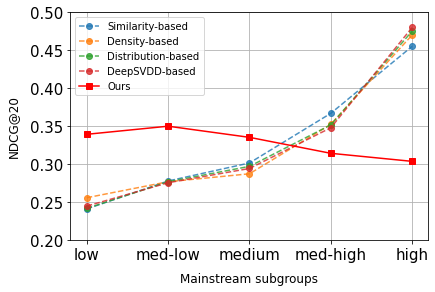

In [15]:
analysis('ML1M')

100%|██████████| 5107/5107 [00:01<00:00, 4033.19it/s]


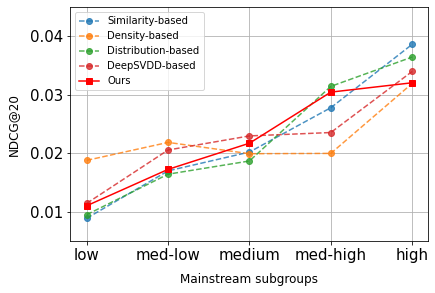

In [17]:
analysis('BookCrossing')

100%|██████████| 13991/13991 [00:04<00:00, 3241.64it/s]


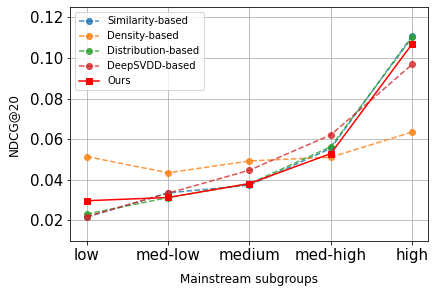

In [19]:
analysis('Yelp')

100%|██████████| 52966/52966 [00:17<00:00, 2964.45it/s]


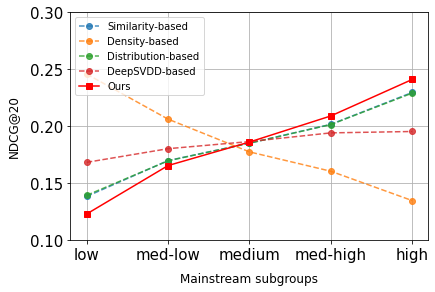

In [21]:
analysis('LFM360K')

100%|██████████| 8521/8521 [00:01<00:00, 4473.53it/s]


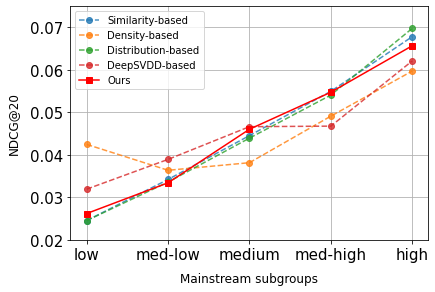

In [23]:
analysis('Epinions')

100%|██████████| 55845/55845 [00:14<00:00, 3905.40it/s]


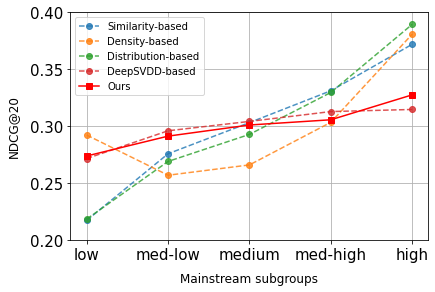

In [25]:
analysis('ML20M')

### Analyze the relationship between user profile size and mainstream score

In [27]:
# divide user into 5 groups
def div_to_five_groups(div_org_array, div_mod_array):
    div_idx = np.argsort(div_org_array)
    bins = 5
    x = np.arange(div_org_array.shape[0])
    x_max = np.max(x)  
    x_min = np.min(x)  
    step = (x_max - x_min) / bins 
    for i in range(bins):
        start = x_min + step * i
        end = x_min + step * (i + 1)
        tmp = div_idx[int(start):int(end)]
        div_mod_array.append(tmp)

In [140]:
def cover_percentage(dataset):
    div_user_pop = []
    div_similarity = []
    div_density = []
    div_distribution = []
    div_DeepSVDD = []
    div_ours = []

    with open('../mod_data/data_statistic.pkl', 'rb') as f:
        info = pickle.load(f)
        num_user = info[dataset][0]
        num_item = info[dataset][1]

    train_df = pd.read_csv('../mod_data/' + dataset + '/sep_data/train_df.csv')

    train_like = list(np.load('../mod_data/' + dataset + '/sep_data/user_train_like.npy', allow_pickle=True))
    test_like = list(np.load('../mod_data/' + dataset + '/sep_data/user_test_like.npy', allow_pickle=True))

    pos_user_array = train_df['userId'].values
    pos_item_array = train_df['itemId'].values
    train_mat = coo_matrix((np.ones(len(pos_user_array)), (pos_user_array, pos_item_array)), shape=(num_user, num_item)).toarray()

    user_pop = np.sum(train_mat, axis=1)
    item_pop = np.sum(train_mat, axis=0)
    user_item_pop = np.sum(train_mat * item_pop.reshape((1, -1)), axis=1) / (np.sum(train_mat, axis=1) + 1e-7)

    Rec = np.load('../mod_data/' + dataset + '/rec_res/Res_VAE.npy')

    user_precision = []
    user_recall = []
    user_ndcg = []
    for u in range(num_user):
        Rec[u, train_like[u]] = -100000.0   # 把训练集出现过的物品，令模型评分调到最低

    for u in tqdm(range(num_user)):
        scores = Rec[u, :]
        top_iid = np.argpartition(scores, -20)[-20:]    # 从scores中挑出最大的那20个，然后返回那20个数在原数组中的索引
        top_iid = top_iid[np.argsort(scores[top_iid])[-1::-1]] # top_iid是一个列表，列表里20个原数组中的索引，这个索引对应的值是从大到小排序的

        # calculate the metrics
        if not len(test_like[u]) == 0: #  若测试集不为空，则计算其指标
            precision_u, recall_u, ndcg_u = user_precision_recall_ndcg(top_iid, test_like[u])
        else:
            precision_u = recall_u = ndcg_u = [-1, -1, -1, -1]
        user_precision.append(precision_u)
        user_recall.append(recall_u)
        user_ndcg.append(ndcg_u)

    ndcg = np.array(user_ndcg)[:, 3]

    MS_similarity = np.load('../evaluation/mainstream_score/' + dataset + '/MS_similarity.npy')
    MS_density = np.load('../evaluation/mainstream_score/' + dataset + '/MS_density.npy')
    MS_distribution = np.load('../evaluation/mainstream_score/' + dataset + '/MS_distribution.npy')
    MS_DeepSVDD = np.load('../evaluation/mainstream_score/' + dataset + '/MS_DeepSVDD.npy')
    MS_ours = np.load('../evaluation/mainstream_score/' + dataset + '/MS_ours.npy')

    div_to_five_groups(user_pop,div_user_pop)
    div_to_five_groups(MS_similarity,div_similarity)
    div_to_five_groups(MS_density,div_density)
    div_to_five_groups(MS_distribution,div_distribution)
    div_to_five_groups(MS_DeepSVDD,div_DeepSVDD)
    div_to_five_groups(MS_ours,div_ours)

    compare_approach = [div_similarity, div_density, div_distribution, div_DeepSVDD, div_ours]

    df_list = []

    for approach in compare_approach:
        sim_list = []
        for i in range(5):
            similarity_to_groups = [0,0,0,0,0]
            for j in approach[i]:
                if j in div_user_pop[0]:
                    similarity_to_groups[0] += 1
                else:
                    if j in div_user_pop[1]:
                        similarity_to_groups[1] += 1 
                    else:
                        if j in div_user_pop[2]:
                            similarity_to_groups[2] += 1 
                        else:
                            if j in div_user_pop[3]:
                                similarity_to_groups[3] += 1 
                            else:
                                similarity_to_groups[4] += 1 
            
            tmp = []
            for k in range(5):
                tmp.append(round(similarity_to_groups[k]/len(div_user_pop[i])*100, 2))
            sim_list.append(tmp)
        sim_list.reverse()
        df = pd.DataFrame(sim_list, columns=["1", "2", "3", "4", "5"])
        df_list.append(df)

    fig = plt.figure(figsize=(25, 10))
    plt.subplots_adjust(left=0.125,
                    bottom=-0.51,
                    right=1.3,
                    top=0.88,
                    wspace=0.2,
                    hspace=0.2
                   )
    plt.subplot(231)
    sns.heatmap(df_list[0], annot=True, cmap='Blues', vmax=90, vmin=0,cbar_kws={'ticks' : [0, 20, 40, 60, 80]} , xticklabels=['low', 'med-low','med', 'med-high', 'high'], yticklabels=['high', 'med-high','med', 'med-low', 'low'])
    plt.title('Similarity-based')
    plt.ylabel('Mainstream score', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.xlabel('Profile size', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.subplot(232)
    sns.heatmap(df_list[1], annot=True, cmap='Blues', vmax=90, vmin=0,cbar_kws={'ticks' : [0, 20, 40, 60, 80]} , xticklabels=['low', 'med-low','med', 'med-high', 'high'], yticklabels=['high', 'med-high','med', 'med-low', 'low'])
    plt.title('Density-based')
    plt.ylabel('Mainstream score', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.xlabel('Profile size', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.subplot(233)
    sns.heatmap(df_list[2], annot=True, cmap='Blues', vmax=90, vmin=0,cbar_kws={'ticks' : [0, 20, 40, 60, 80]} , xticklabels=['low', 'med-low','med', 'med-high', 'high'], yticklabels=['high', 'med-high','med', 'med-low', 'low'])
    plt.title('Distribution-based')
    plt.ylabel('Mainstream score', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.xlabel('Profile size', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.subplot(234)
    sns.heatmap(df_list[3], annot=True, cmap='Blues', vmax=90, vmin=0,cbar_kws={'ticks' : [0, 20, 40, 60, 80]} , xticklabels=['low', 'med-low','med', 'med-high', 'high'], yticklabels=['high', 'med-high','med', 'med-low', 'low'])
    plt.title('DeepSVDD-based')
    plt.ylabel('Mainstream score', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.xlabel('Profile size', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.subplot(235)
    plt.title('Ours')
    sns.heatmap(df_list[4], annot=True, cmap='Blues', vmax=90, vmin=0,cbar_kws={'ticks' : [0, 20, 40, 60, 80]} , xticklabels=['low', 'med-low','med', 'med-high', 'high'], yticklabels=['high', 'med-high','med', 'med-low', 'low'])
    plt.ylabel('Mainstream score', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    plt.xlabel('Profile size', labelpad=10, fontdict={'fontsize' : '12', 'fontweight' : 'bold'})
    # plt.savefig('../results/heat_ml1m/' + f'{ptitle}.svg', dpi=300, bbox_inches='tight')


100%|██████████| 6040/6040 [00:01<00:00, 5272.15it/s]


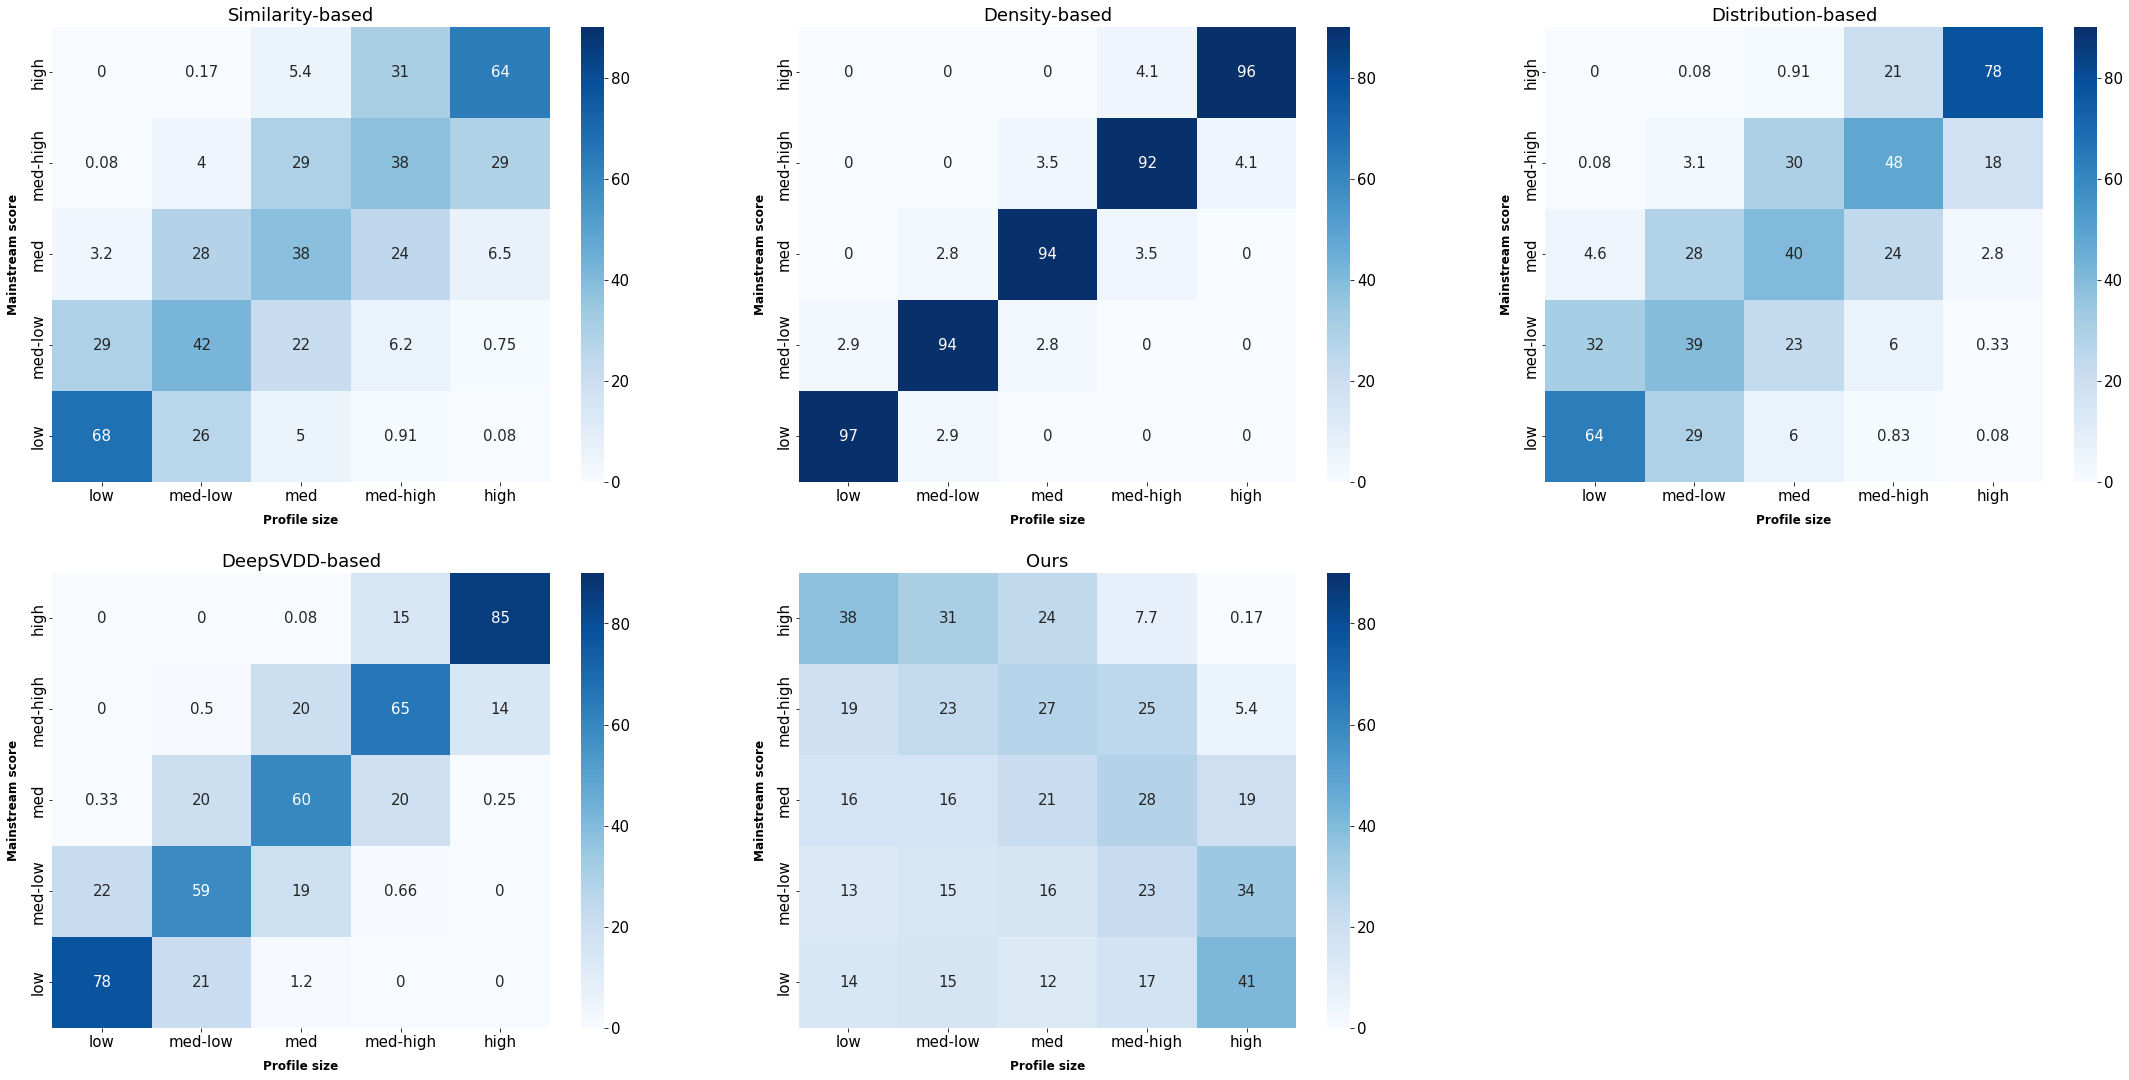

In [141]:
cover_percentage('ML1M')

100%|██████████| 55845/55845 [00:14<00:00, 3790.55it/s]


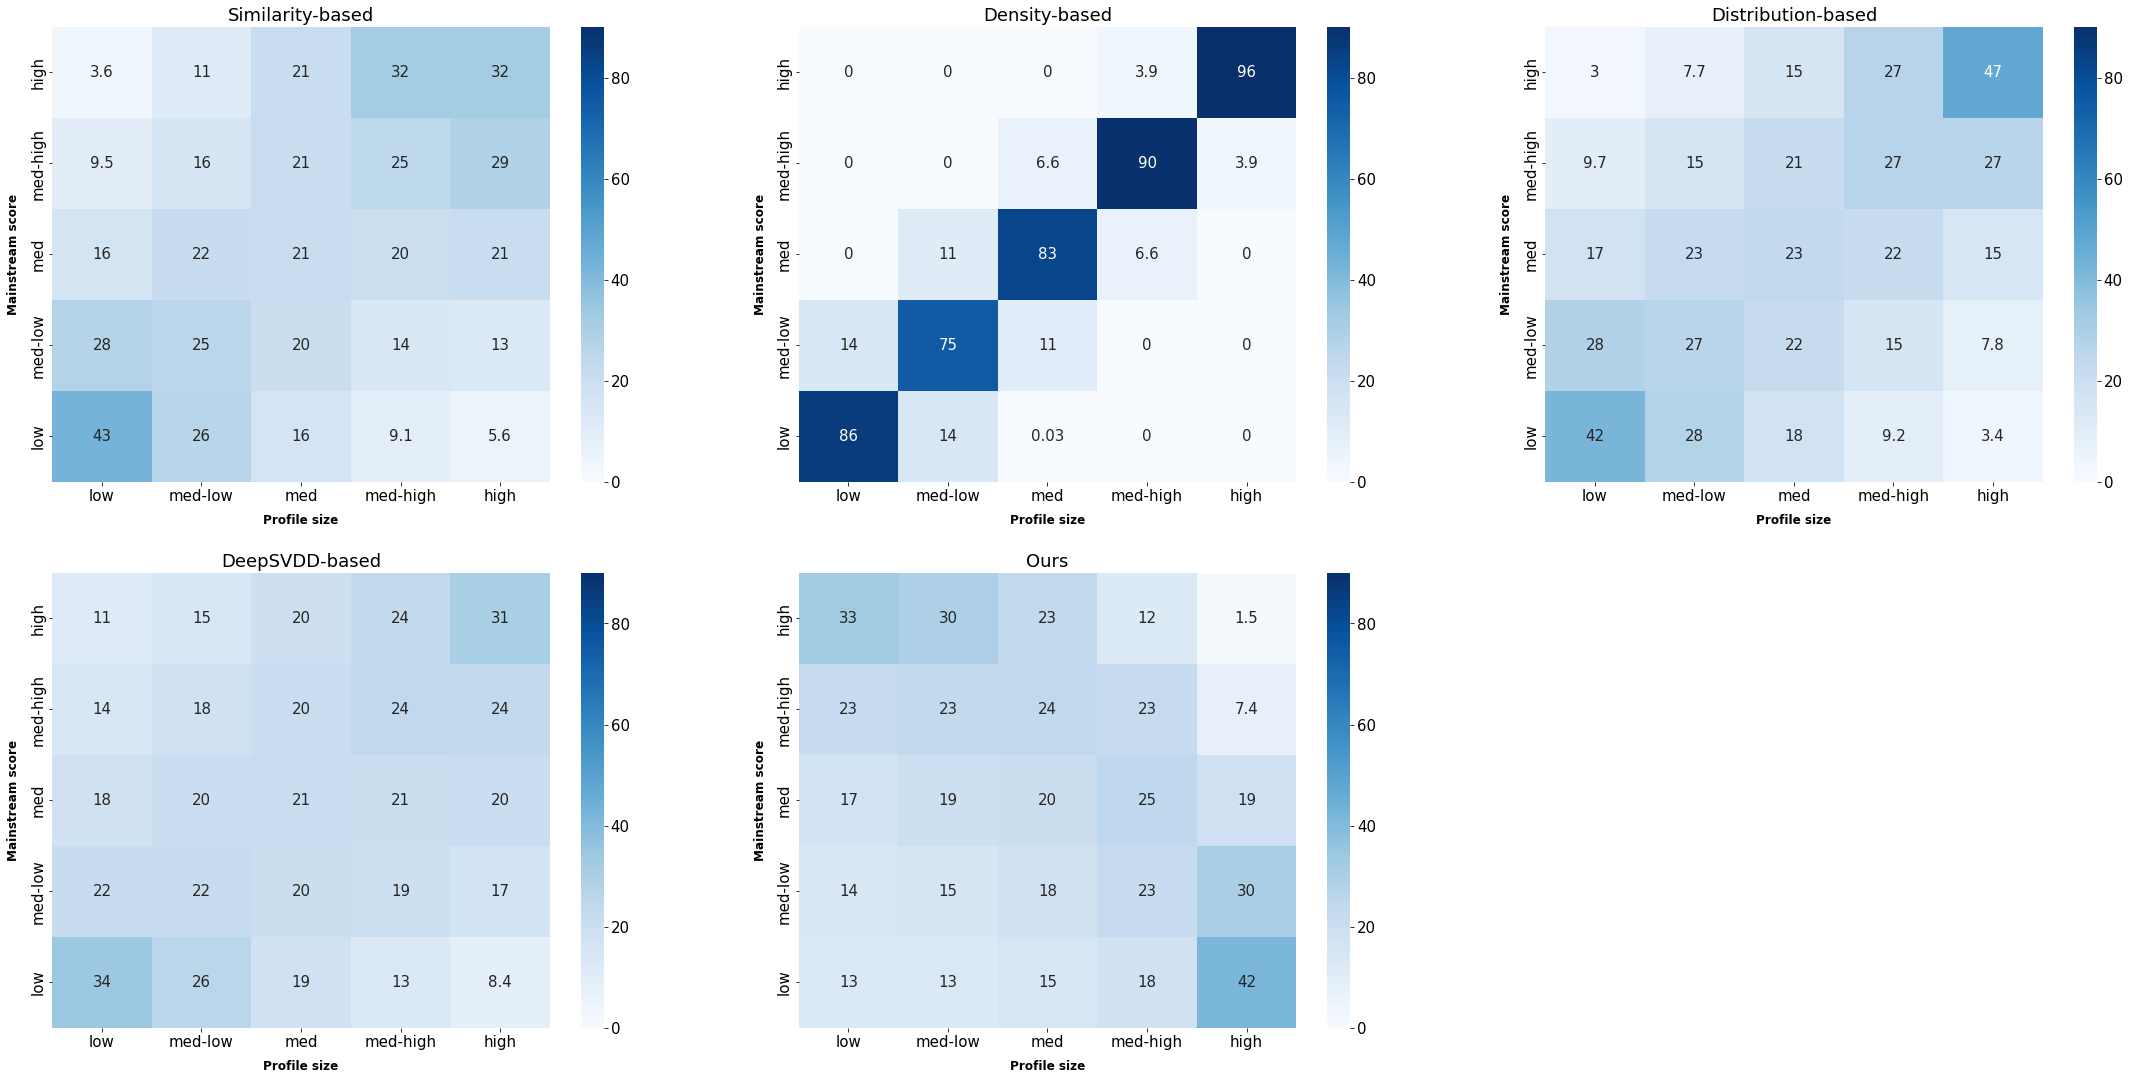

In [142]:
cover_percentage('ML20M')

100%|██████████| 52966/52966 [00:18<00:00, 2892.91it/s]


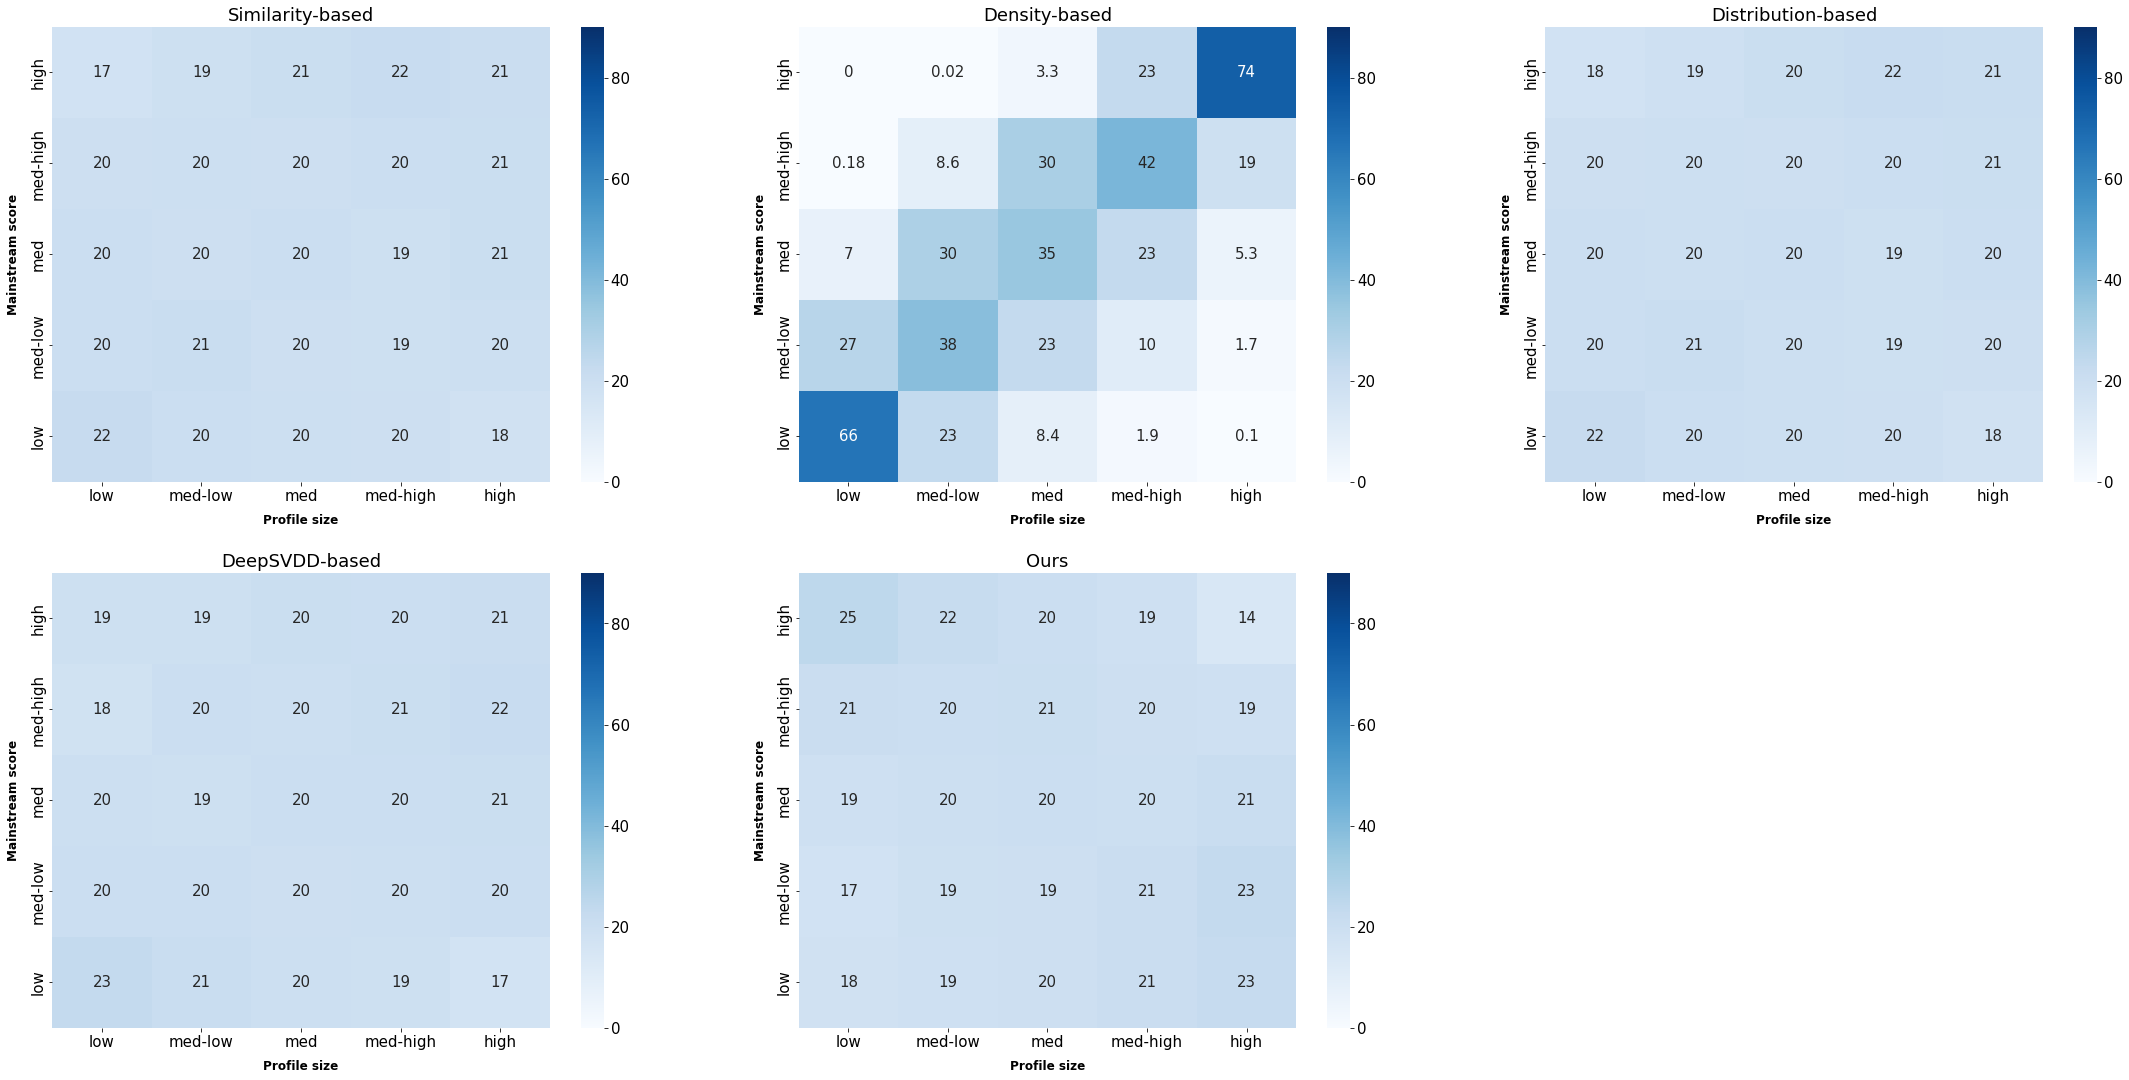

In [143]:
cover_percentage('LFM360K')

100%|██████████| 5107/5107 [00:01<00:00, 4034.60it/s]


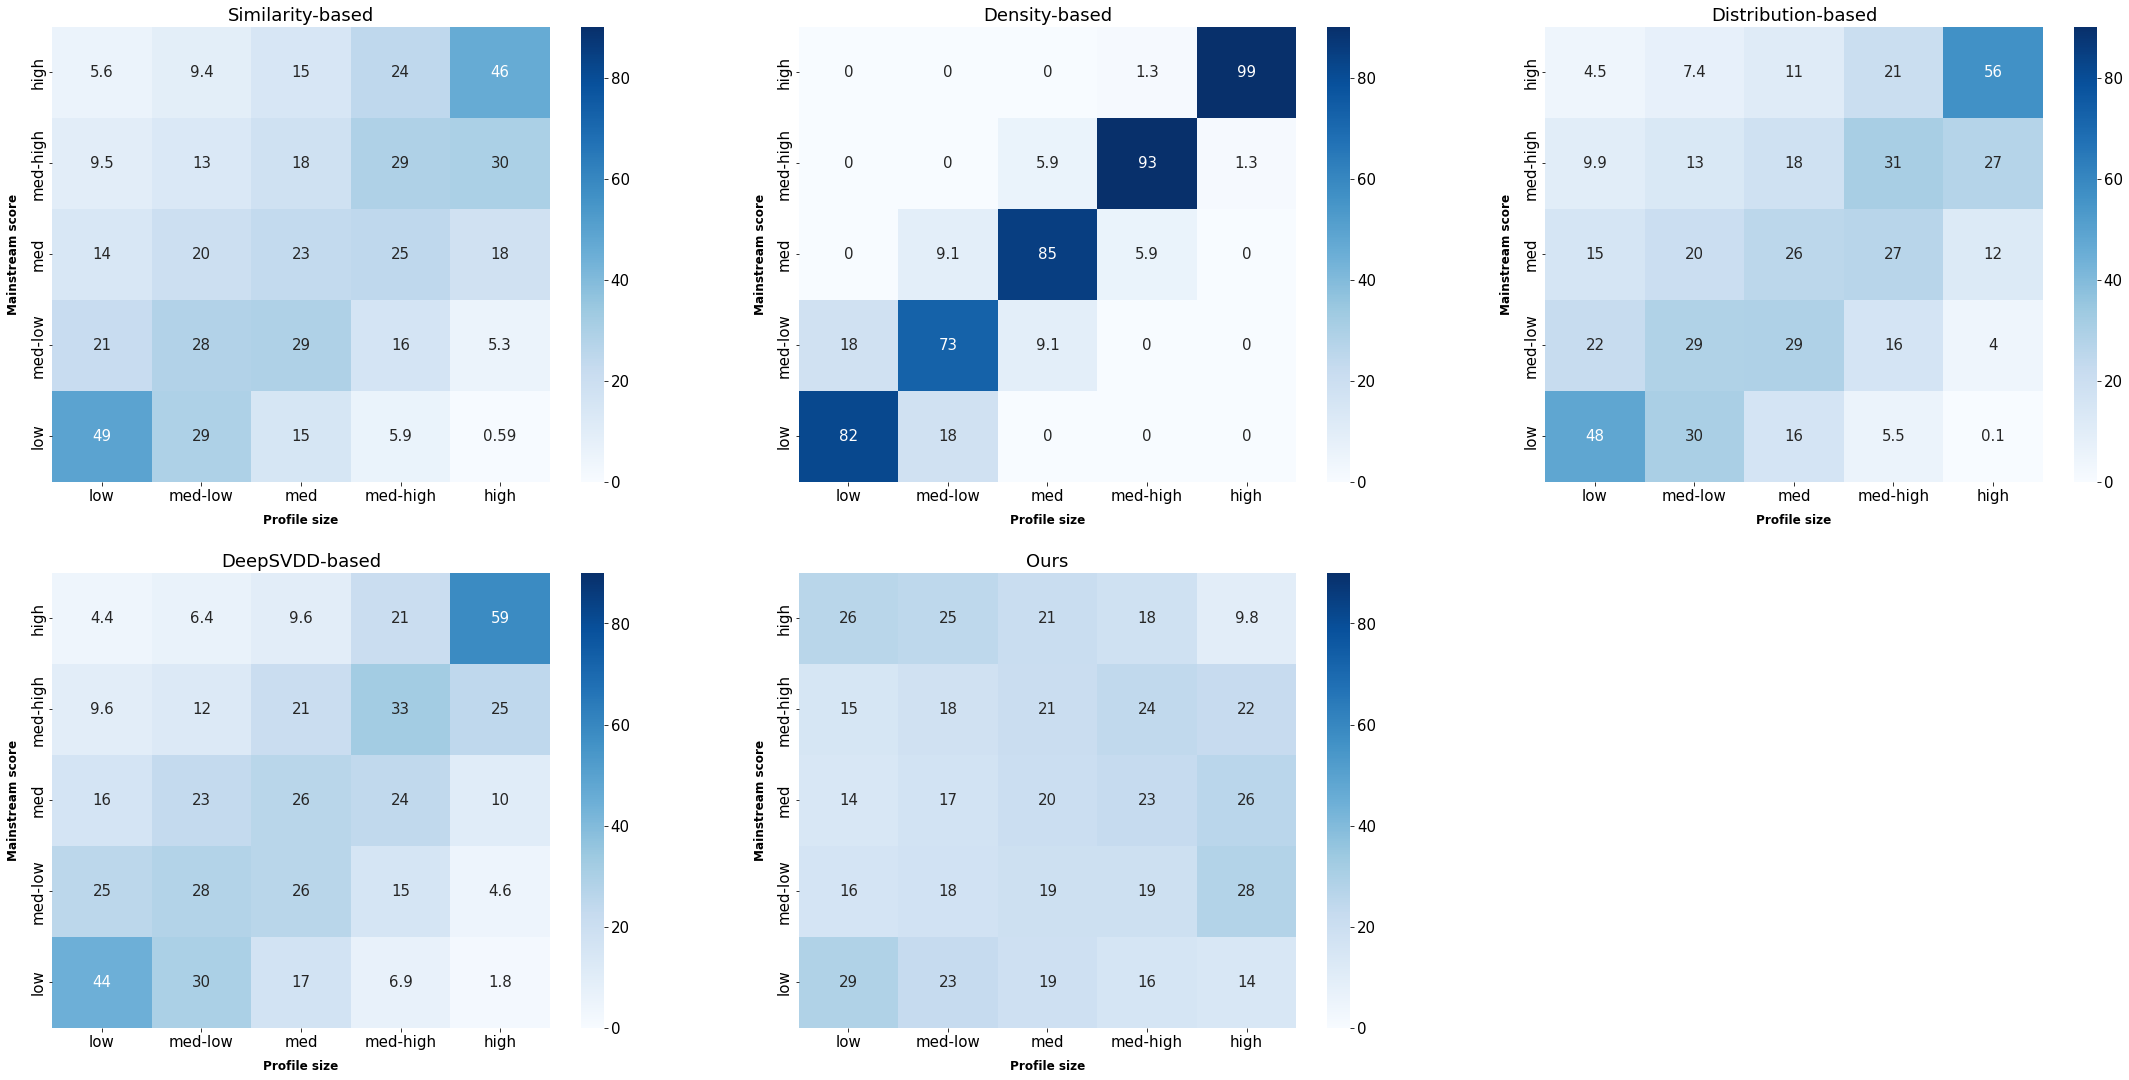

In [144]:
cover_percentage('BookCrossing')

100%|██████████| 13991/13991 [00:04<00:00, 3257.04it/s]


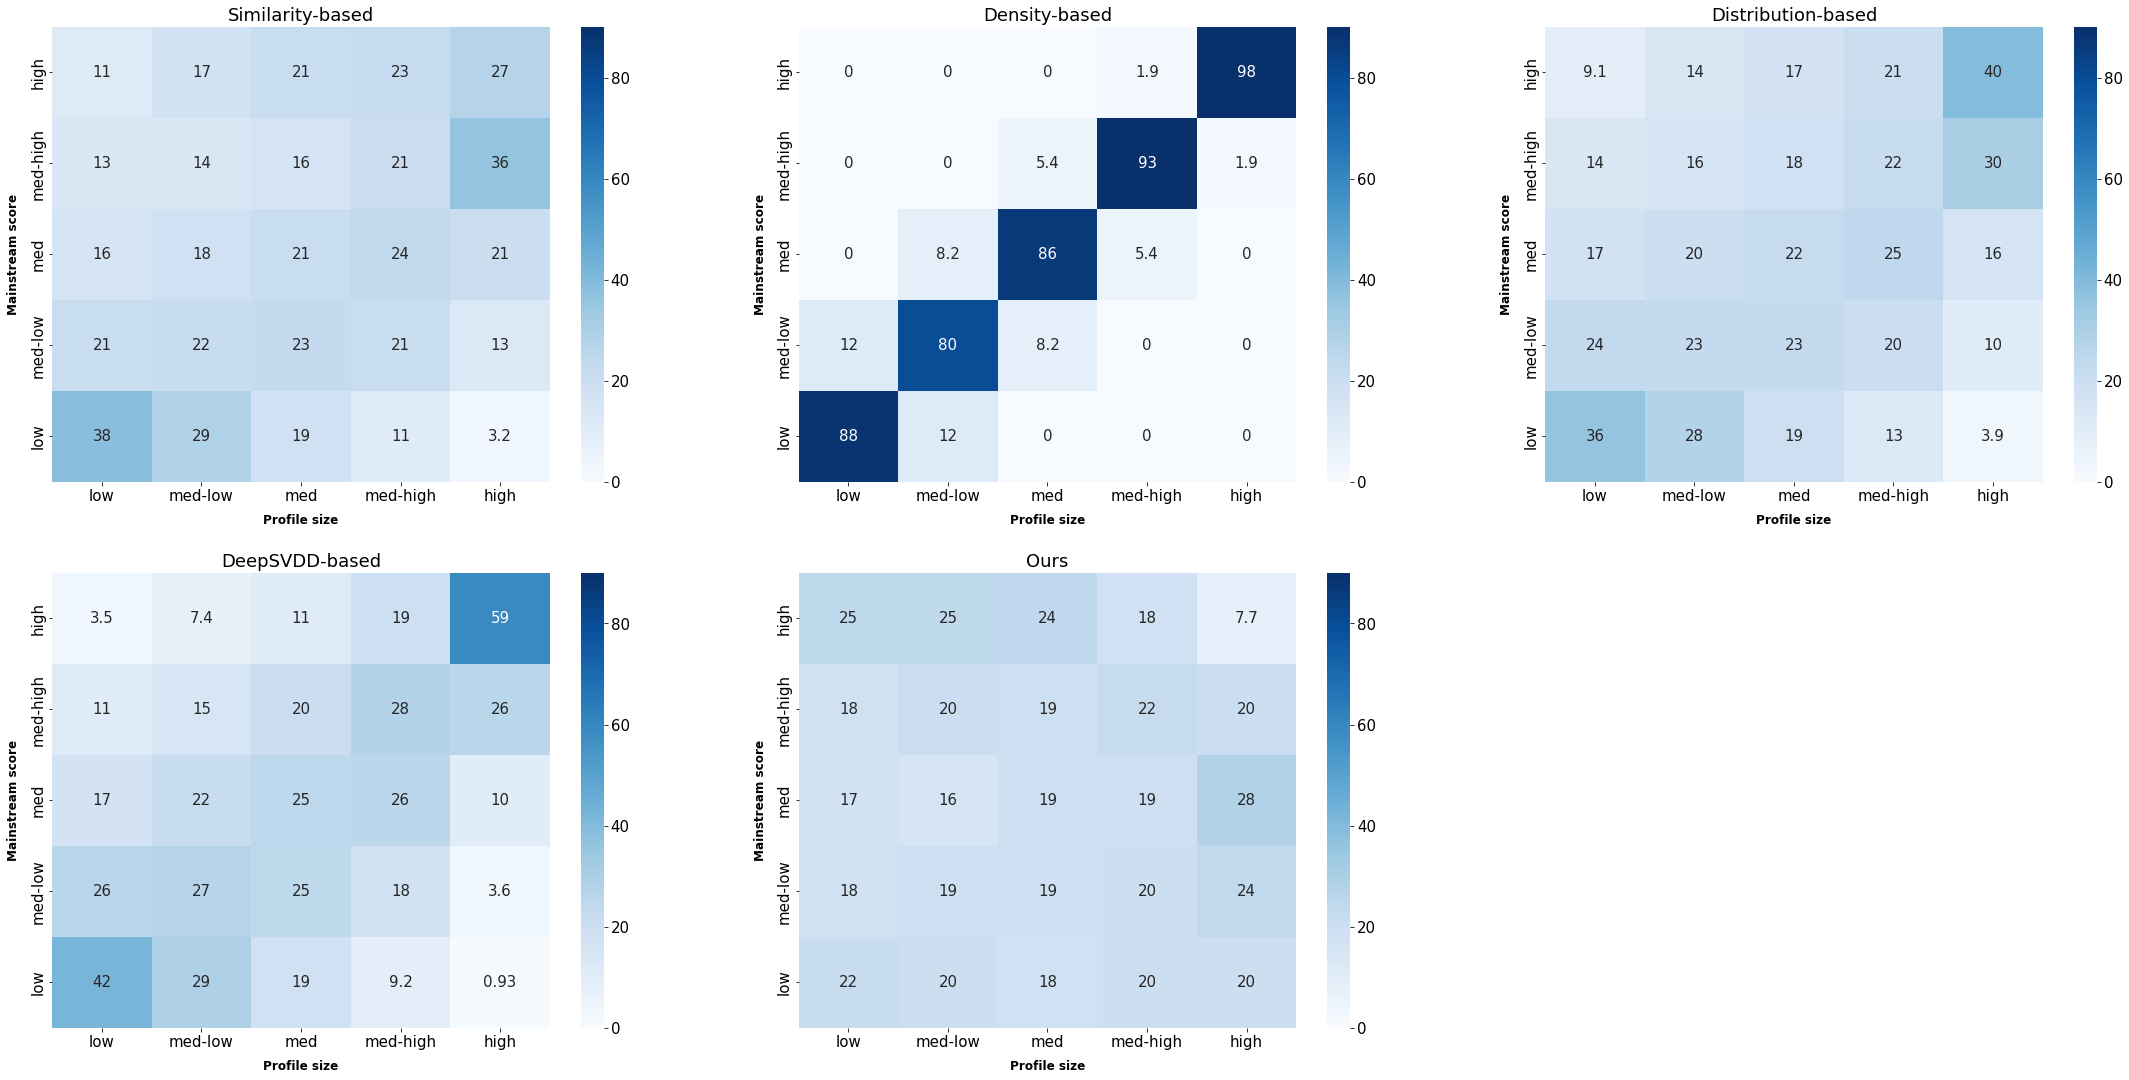

In [145]:
cover_percentage('Yelp')

100%|██████████| 8521/8521 [00:01<00:00, 4341.27it/s]


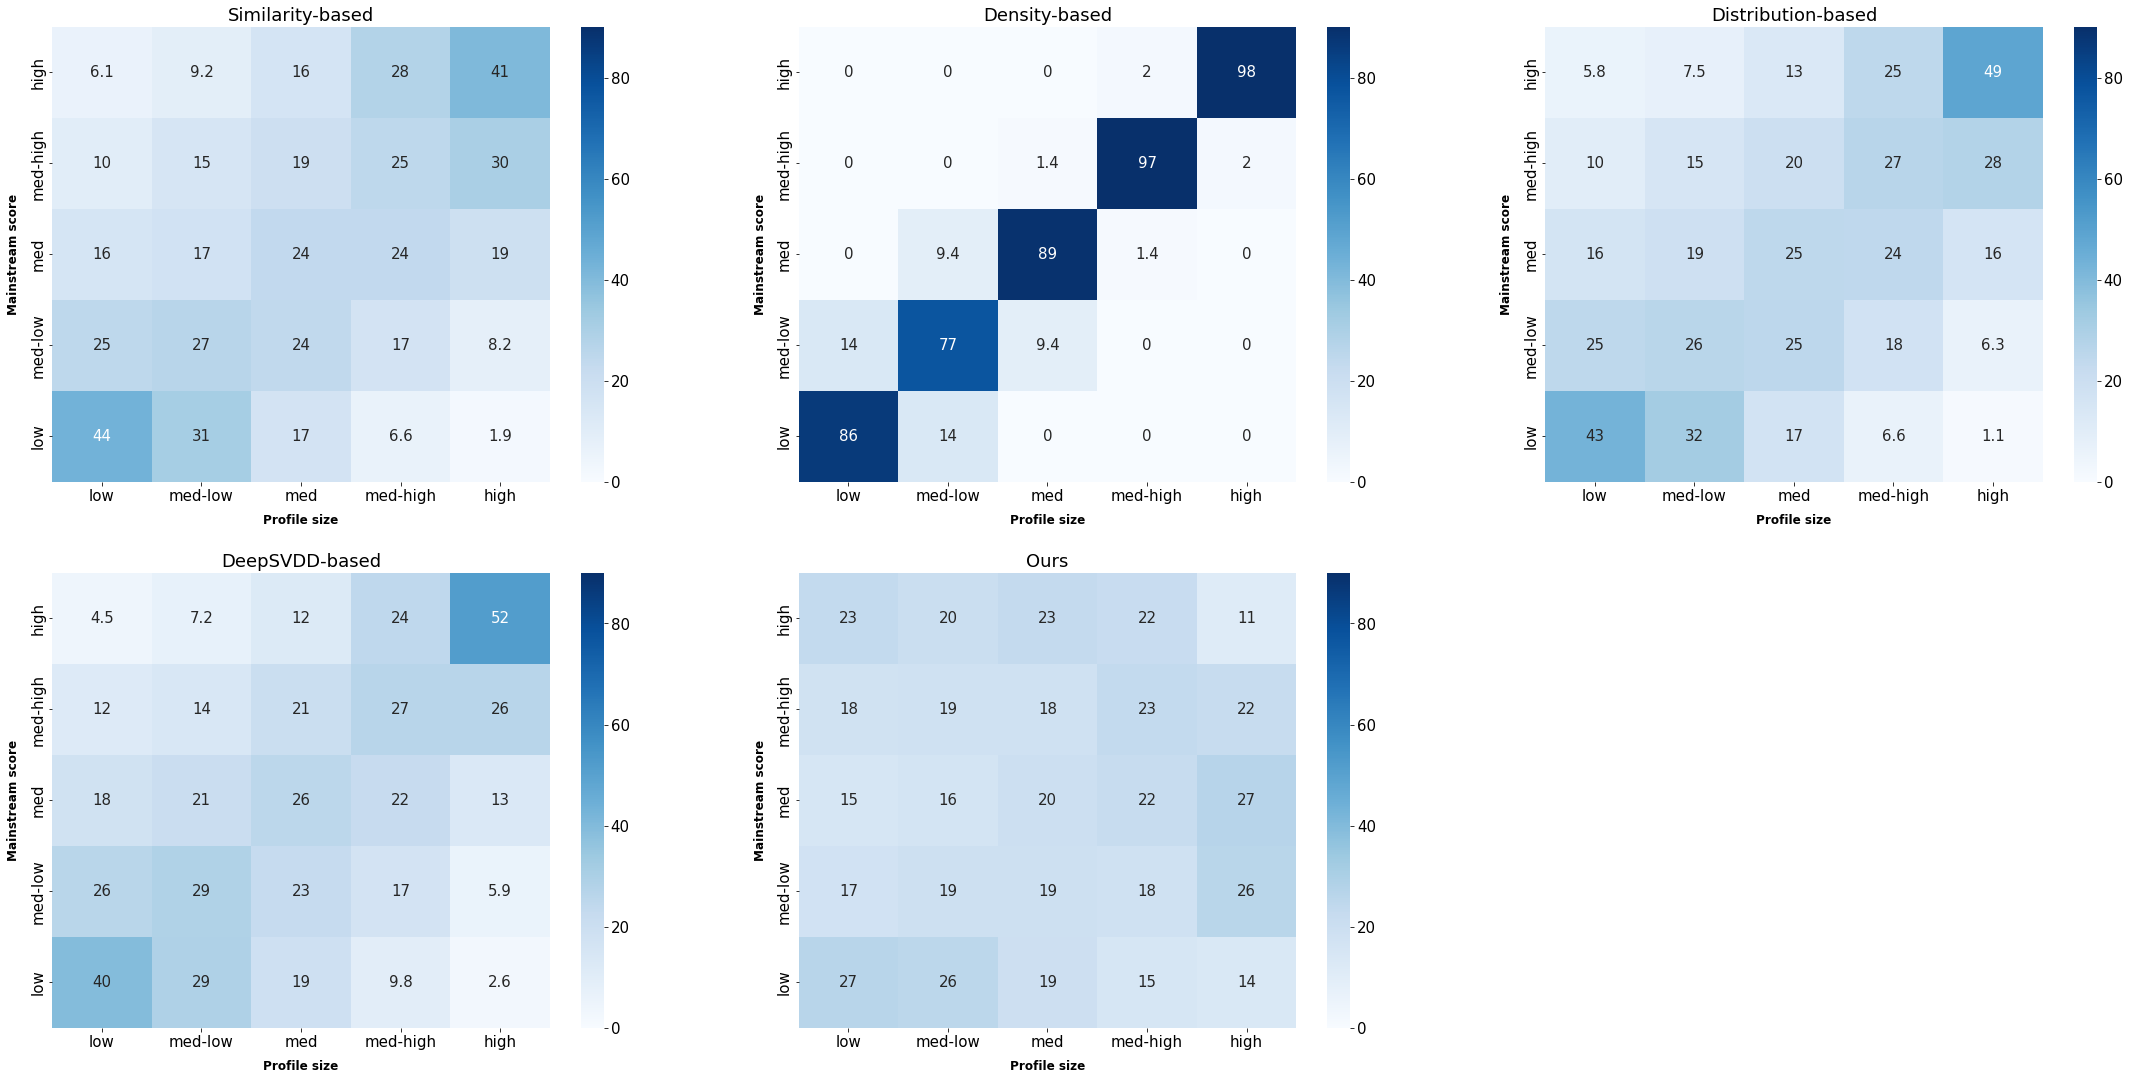

In [146]:
cover_percentage('Epinions')